#**Часть первая: перенос стиля при помощи pix2pix**

In [1]:
import os
from os.path import join
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torch.utils.data as data

from PIL import Image


Я работаю с данными facades, где картинки уже разбиты на группы а и b, то есть уже отдельно сложены трафареты и настоящие фотографии

In [ ]:
!unzip facades.zip

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = 4
batch_size = 8
image_size = 300

In [3]:
transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                  transforms.Resize((300,300))]

transform = transforms.Compose(transform_list)

In [4]:
class DatasetFacades(data.Dataset):
    def __init__(self, image_dir):
        super(DatasetFacades, self).__init__()
        self.a_path = join(image_dir, "a")
        self.b_path = join(image_dir, "b")
        self.image_filenames = [x for x in os.listdir(self.a_path)]

        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          transforms.Resize((300,300))]

        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(join(self.b_path, self.image_filenames[index])).convert('RGB')

        a = self.transform(a)
        b = self.transform(b)

        return b, a

    def __len__(self):
        return len(self.image_filenames)


In [5]:
train_set = DatasetFacades('facades/train/')
test_set = DatasetFacades('facades/test/')
training_data_loader = data.DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
testing_data_loader = data.DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

In [6]:
len(training_data_loader.dataset), len(testing_data_loader.dataset)

(400, 206)

In [7]:
class Resnet_block(nn.Module):
    def __init__(self, hid_dim):
        super(Resnet_block, self).__init__()
        self.block = nn.Sequential(nn.Conv2d(hid_dim, hid_dim, kernel_size = 3, padding=1),nn.BatchNorm2d(hid_dim), nn.ReLU(inplace=True))
    def forward(self, x):
        return nn.ReLU(True)(x + self.block(x))

class Generator(nn.Module):
    def __init__(self, num_channels=3):
        super(Generator, self).__init__()

        def generator_block(in_filters, out_filters):
            block = [nn.Conv2d(in_filters, out_filters, kernel_size = 3, padding=1),nn.BatchNorm2d(out_filters), nn.ReLU(inplace=True)]
            return block

        self.conv_blocks = nn.Sequential(
                        *generator_block(num_channels, 16),
                        *generator_block(16, 32),
                        *generator_block(32, 64),
                        *generator_block(64, 128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),
                        Resnet_block(128),     
                        Resnet_block(128),
                        Resnet_block(128),                   
                        *generator_block(128, num_channels),
                        nn.Tanh()
                          )


    def forward(self, z):
        out = self.conv_blocks(z)
        return out

class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(num_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            nn.Conv2d(128, 1, kernel_size=3, stride=1)
        )


        ds_size = image_size
        for _ in range(4):
            ds_size = int(ds_size / 2.)
        self.adv_layer = nn.Linear((int(ds_size)-1) **2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


L1_loss = nn.L1Loss().to(device)
MSE_loss = nn.MSELoss().to(device)


In [11]:
lr = 0.0005
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
num_epochs = 20
alpha = 8
for epoch in range(num_epochs):
    losses_g = []
    losses_d = []
    for batch in training_data_loader:
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = generator(real_a)

        # train discriminator
        optimizer_D.zero_grad()
        
 
        fake_ab = torch.cat((real_a, fake_b), 0)
        pred_fake = discriminator.forward(fake_ab.detach())
        loss_d_fake = MSE_loss(pred_fake, torch.tensor(0.0).expand_as(pred_fake).to(device))


        real_ab = torch.cat((real_a, real_b), 0)
        pred_real = discriminator.forward(real_ab)
        loss_d_real = MSE_loss(pred_real, torch.tensor(1.0).expand_as(pred_real).to(device))

        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()      
        optimizer_D.step()

        # train generator

        optimizer_G.zero_grad()

        fake_ab = torch.cat((real_a, fake_b), 0)
        pred_fake = discriminator.forward(fake_ab)
        loss_g_gan = MSE_loss(pred_fake, torch.tensor(1.0).expand_as(pred_fake).to(device))

        loss_g_l1 = L1_loss(fake_b, real_b) * alpha
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()
        optimizer_G.step()

        losses_g.append(loss_g.detach().cpu().numpy())
        losses_d.append(loss_d.detach().cpu().numpy())

    print(f"Epoch {epoch}: loss_d: {round(np.mean(losses_d),4)} loss_g: {round(np.mean(losses_g),4)}")


Epoch 0: loss_d: 0.5910000205039978 loss_g: 3.813999891281128
Epoch 1: loss_d: 0.3352999985218048 loss_g: 3.6826000213623047
Epoch 2: loss_d: 0.15389999747276306 loss_g: 3.8912999629974365
Epoch 3: loss_d: 0.07519999891519547 loss_g: 4.07859992980957
Epoch 4: loss_d: 0.051100000739097595 loss_g: 4.123300075531006
Epoch 5: loss_d: 0.04639999940991402 loss_g: 4.143400192260742
Epoch 6: loss_d: 0.039799999445676804 loss_g: 4.146100044250488
Epoch 7: loss_d: 0.03590000048279762 loss_g: 4.192699909210205
Epoch 8: loss_d: 0.02800000086426735 loss_g: 4.170199871063232
Epoch 9: loss_d: 0.02879999950528145 loss_g: 4.153600215911865
Epoch 10: loss_d: 0.02669999934732914 loss_g: 4.169600009918213
Epoch 11: loss_d: 0.025100000202655792 loss_g: 4.1774001121521
Epoch 12: loss_d: 0.02280000038444996 loss_g: 4.168600082397461
Epoch 13: loss_d: 0.019999999552965164 loss_g: 4.191999912261963
Epoch 14: loss_d: 0.019500000402331352 loss_g: 4.173399925231934
Epoch 15: loss_d: 0.018699999898672104 loss_g: 4

In [ ]:
generator.eval()

In [60]:
image_dir_b = "facades/test/b/"
image_dir_a = "facades/test/a/"
image_filenames_b = [x for x in os.listdir(image_dir_b)]

Проверим, что получим на тесте:

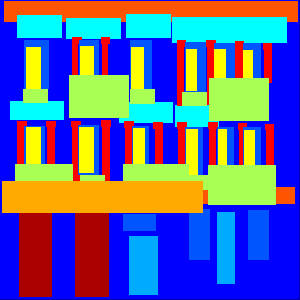

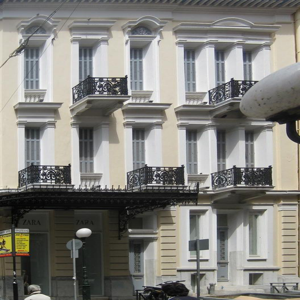

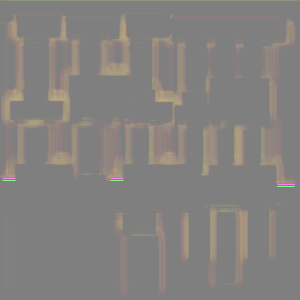

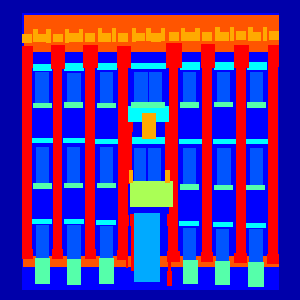

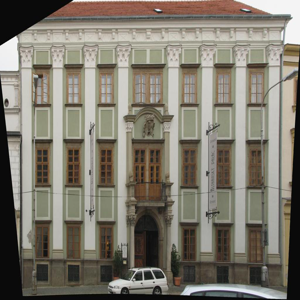

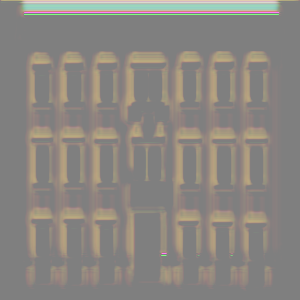

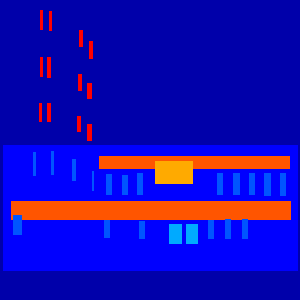

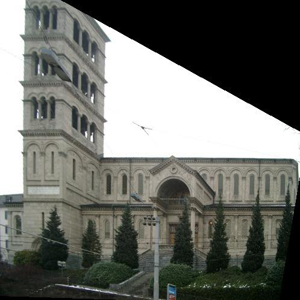

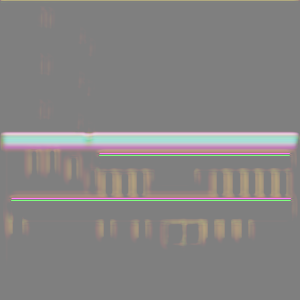

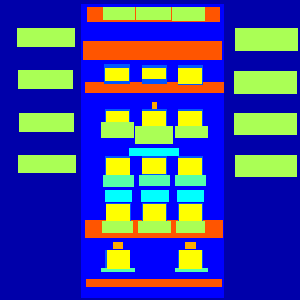

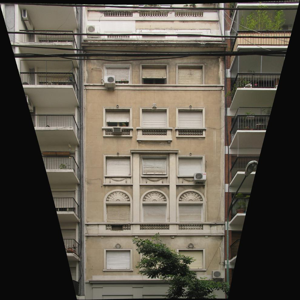

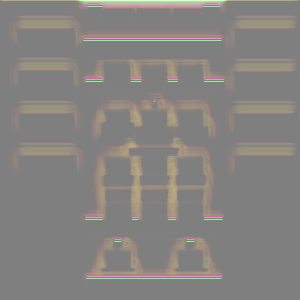

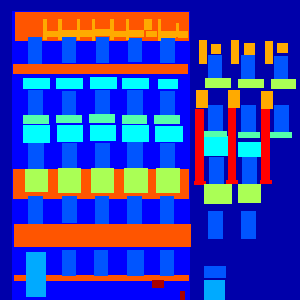

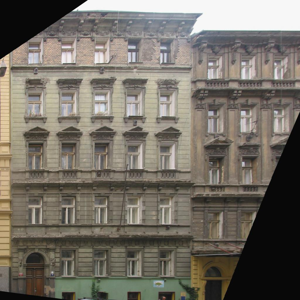

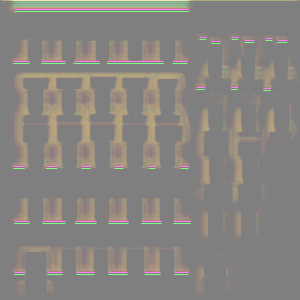

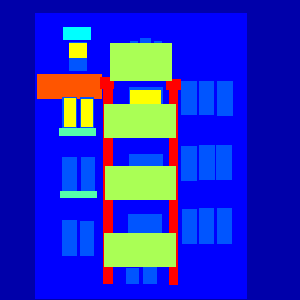

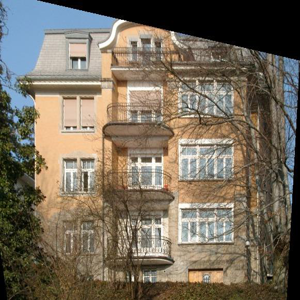

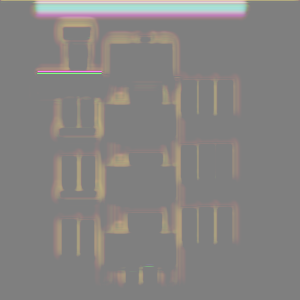

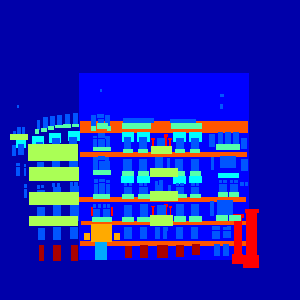

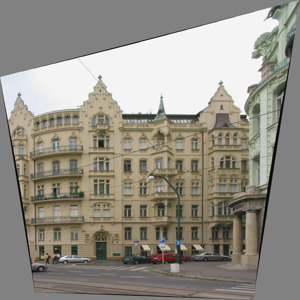

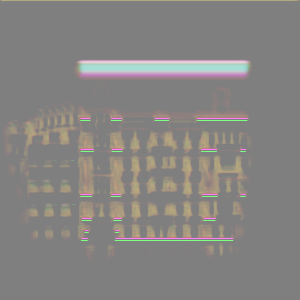

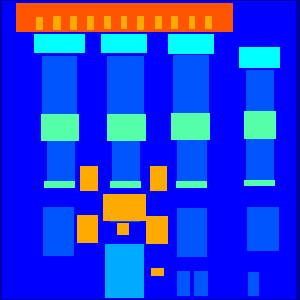

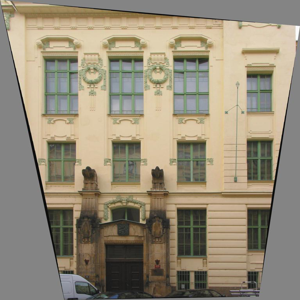

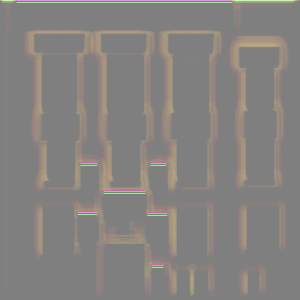

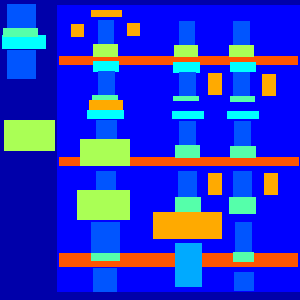

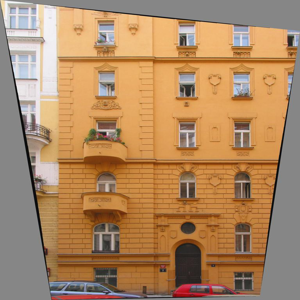

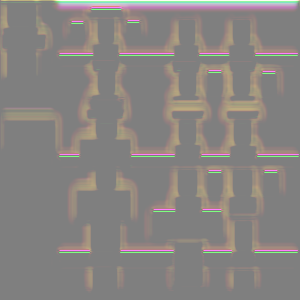

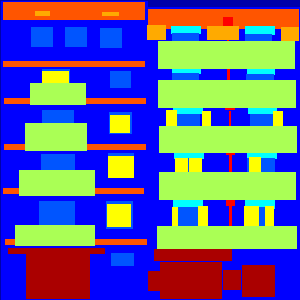

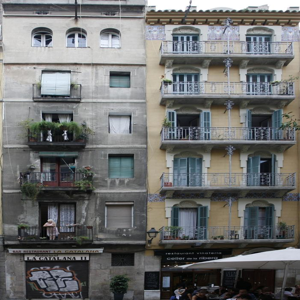

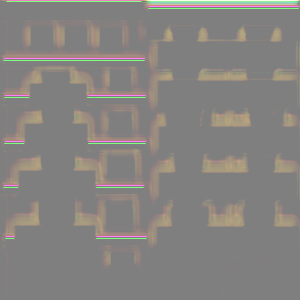

In [61]:
for image_name in image_filenames_b[:10]:
    img = Image.open(image_dir_b + image_name)
    img = transform(img)
    input = img.unsqueeze(0).to(device)
    out = generator(input)
    out_img = out.detach().squeeze(0).cpu()

    # source picture
    img_source = Image.open(image_dir_b + image_name)
    display(img_source)
    # real facade
    img_facade = Image.open(image_dir_a + image_name)
    display(img_facade)
    out_img = out_img.permute(1,2,0)
    image_numpy = (out_img.float().numpy() + 1)/2 * 255
    image_numpy = image_numpy.clip(0, 255)
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    # from generator
    display(image_pil)
    print('\n\n\n')

